In [43]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
mpl.rcParams["font.family"] = "SimHei"

# Open the FITS file
hdulist = fits.open('glg_tte_b0_bn230512269_v00.fits')

# Access the data in the primary HDU (Header Data Unit)
data = hdulist[1].data

# Optionally, access the header information
header = hdulist[1].header
header

In [44]:
# data = hdulist[2].data

# # Optionally, access the header information
# header = hdulist[2].header
# header

In [45]:
hdulist.info()

Filename: glg_tte_b0_bn230512269_v00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     48   293077R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   


In [46]:
data = hdulist[2].data
print(data.shape)

(293077,)


In [47]:
data0 = np.array(data)
data0.shape

(293077,)

In [48]:
from astropy.table import Table
lamost = Table.read('glg_tte_b0_bn230512269_v00.fits', hdu=2)
lamost = lamost.to_pandas()
# lamost.set_index('TIME', inplace=True)
# lamost

,TIME,PHA
0,7.055655e+08,39
1,7.055655e+08,4
2,7.055655e+08,127
3,7.055655e+08,6
4,7.055655e+08,0
...,...,...
293072,7.055657e+08,38
293073,7.055657e+08,127
293074,7.055657e+08,1
293075,7.055657e+08,31


In [50]:
start = lamost['TIME'].iloc[0]
end = lamost['TIME'].iloc[-1]
total_range = end - start
total_range

197.6348079442978

In [51]:
ENOUNDS = Table.read('glg_tte_b0_bn230512269_v00.fits', hdu=1)
ENOUNDS = ENOUNDS.to_pandas()
# lamost.set_index('TIME', inplace=True)
ENOUNDS['MEAN'] = (ENOUNDS['E_MIN'] + ENOUNDS['E_MAX'])/2
ENOUNDS.set_index('CHANNEL', inplace=True)
ENOUNDS

,E_MIN,E_MAX,MEAN
CHANNEL,,,
0,113.248123,216.706970,164.977539
1,216.706970,250.773270,233.740112
2,250.773270,284.649506,267.711395
3,284.649506,318.347656,301.498596
4,318.347656,351.879639,335.113647
...,...,...,...
123,36027.074219,37989.234375,37008.156250
124,37989.234375,40107.546875,39048.390625
125,40107.546875,42526.738281,41317.140625


In [52]:
lamost_time_index = lamost.set_index('TIME')
lamost_time_index

,PHA
TIME,
7.055655e+08,39
7.055655e+08,4
7.055655e+08,127
7.055655e+08,6
7.055655e+08,0
...,...
7.055657e+08,38
7.055657e+08,127
7.055657e+08,1


In [53]:
import numba

# @numba.jit('float64[:, :](int32, int32)', nopython=False, nogil=True, parallel=True)
def get_data(step, total_range):
    step = 6100
    h = total_range/step
    times_count = np.zeros((step, 2))
    # counts = np.zeros(step)
    for i in range(step):
        start_ = start + h*i
        end_ = start + h*(i+1)
        # indexes.append()
        target_df = lamost[(lamost['TIME'] - start_)*(lamost['TIME'] - end_) < 0]
        # print(target_df)
        times_count[i, 0] = target_df['TIME'].mean()
        count = target_df.count()[0]
        times_count[i, 1] = count
    return times_count

times_count = get_data(6100, total_range)
df = pd.DataFrame({'TIME': times_count[:, 0], 'COUNTS': times_count[:, 1]})
df.set_index('TIME', inplace=True)

In [54]:
lamost['Energy'] = lamost['PHA'].apply(lambda x: ENOUNDS.loc[x, 'MEAN'])

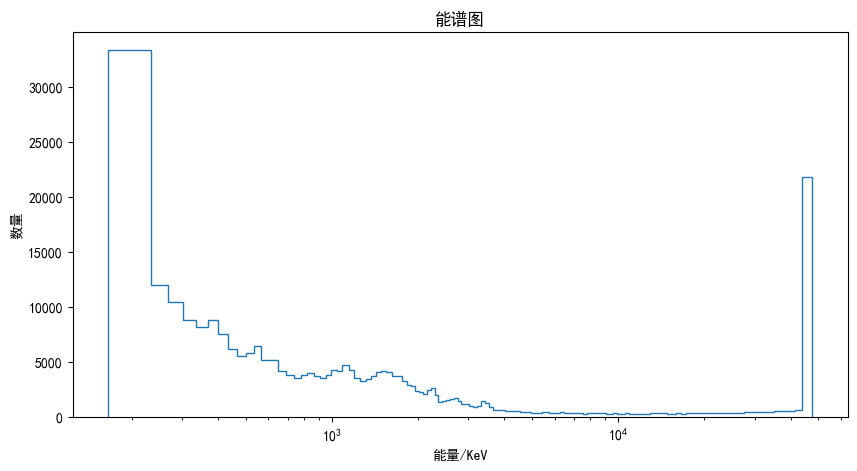

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.hist(lamost['Energy'], bins=ENOUNDS['MEAN'].to_numpy(), histtype='step');
# set log scale of x
ax.set_xscale('log')
ax.set_xlabel('能量/KeV')
ax.set_ylabel('数量')
ax.set_title('能谱图')
fig.savefig('能谱图.png', dpi=300)
# ax.set_ylim([0, 160])

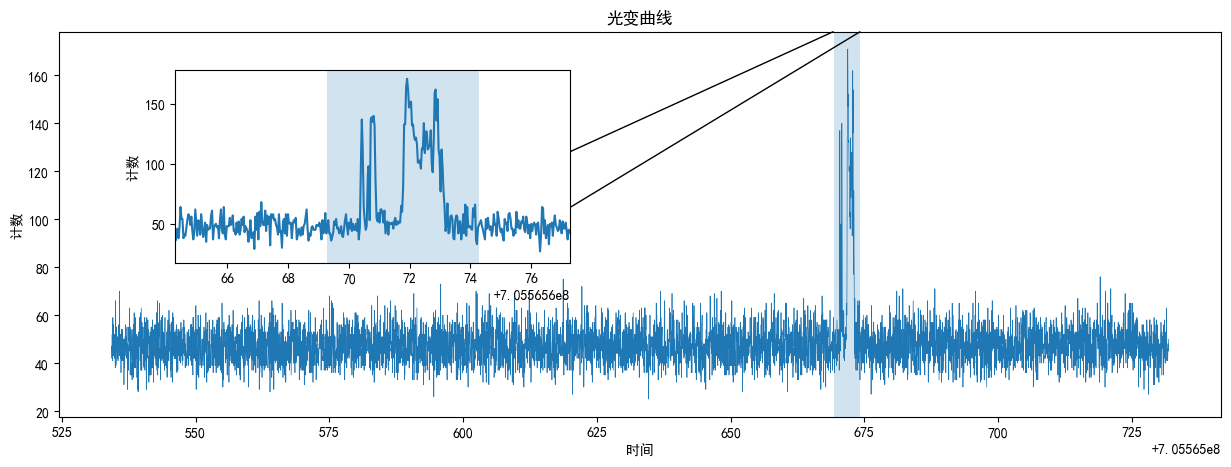

In [56]:
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector, BboxConnectorPatch


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, ax1.get_xaxis_transform())
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


# axs = plt.figure(figsize=(15, 6)).subplot_mosaic([
#     ["zoom"],
#     ["main"],
# ])
fig, ax = plt.subplots(figsize=(15, 5))
ax_inset = ax.inset_axes([0.1, 0.4, 0.34, 0.5])

base = df.index[0]
ax.plot(df.index.to_list(), df.COUNTS, linewidth=0.5)
# ax.set(xlim=(0, 5))
ax_inset.plot(df.index, df.COUNTS)
ax_inset.set_xlim( base + 130, base + 143)
zoom_effect01(ax_inset, ax, base + 135, base + 140)
# axs["zoom2"].set(xlim=(2, 3))
# zoom_effect02(axs["zoom2"], ax)
# set axis name
ax.set_xlabel('时间')
ax.set_ylabel('计数')
# axs["zoom1"].set_xlabel('TIME')
ax_inset.set_ylabel('计数')
# set title for the plot
ax.set_title('光变曲线')
plt.savefig('光变曲线（放大）.png', dpi=600)